<a href="https://colab.research.google.com/github/otvet4ikov/different_notebooks/blob/main/titanic_with_drop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score, auc, roc_curve
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.decomposition import PCA


In [ ]:
df = pd.read_csv('./train.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
df = df.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1)
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
df.shape

(891, 8)

In [ ]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

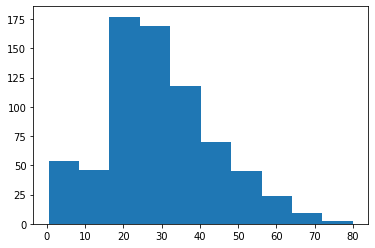

In [ ]:
plt.hist(df.Age)
plt.show()

In [ ]:
df.Sex = np.where(df.Sex == 'female', 1, 0)

1 Подход. Удалим все None в таблице (потеряем 177 записей, что около 20%) и посмотрим как алгоритмы будут работать в этой ситуации

In [ ]:
df_drop = df.dropna()



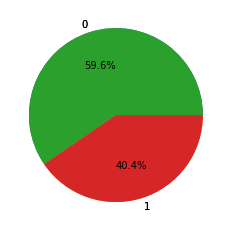

0    424
1    288
Name: Survived, dtype: int64

In [ ]:
values_drop = df_drop['Survived'].value_counts()
labels = df_drop['Survived'].unique()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(values_drop, labels=labels, autopct='%1.1f%%')
ax.pie(values_drop, labels=labels)
plt.show()
values_drop

In [ ]:
from sklearn.utils import resample, shuffle

In [ ]:
one = df_drop[df_drop['Survived'] == 1]
zero = df_drop[df_drop['Survived'] == 0]


resampled = resample(one, replace = True, n_samples = 424)

df_drop = pd.concat([zero, resampled])
df_drop = shuffle(df_drop)
df_drop.Age = df_drop.Age.astype(int)
X_drop = pd.get_dummies(df_drop.drop('Survived', axis = 1))
y_drop = df_drop['Survived']
df_drop.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.367781,0.499332,-0.082148,0.015415,0.114225,0.280777
Pclass,-0.367781,1.000000,-0.140500,-0.359024,0.039380,0.028350,-0.590252
Sex,0.499332,-0.140500,1.000000,-0.065219,0.115798,0.219791,0.232120
Age,-0.082148,-0.359024,-0.065219,1.000000,-0.281496,-0.219843,0.100433
SibSp,0.015415,0.039380,0.115798,-0.281496,1.000000,0.369862,0.175372
Parch,0.114225,0.028350,0.219791,-0.219843,0.369862,1.000000,0.222643
Fare,0.280777,-0.590252,0.232120,0.100433,0.175372,0.222643,1.000000


In [ ]:
df_drop_lr = df_drop.copy()
df_drop_lr['p1'] = np.where(df_drop_lr['Pclass'] == 1, 1, 0)
df_drop_lr['p2'] = np.where(df_drop_lr['Pclass'] == 2, 1, 0)
df_drop_lr['p3'] = np.where(df_drop_lr['Pclass'] == 3, 1, 0)
df_drop_lr = df_drop_lr.drop('Pclass', axis = 1)
df_drop_lr = pd.get_dummies(df_drop_lr)
df_drop_lr.drop('SibSp', axis = 1).corr()
X_drop_lr = df_drop_lr.drop('Survived', axis = 1)
y_drop_lr = df_drop_lr['Survived']

In [ ]:
sc = StandardScaler()
features= X_drop_lr.columns
X_drop_lr[features] = sc.fit_transform(X_drop_lr[features])

In [ ]:
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size = 0.1, random_state = 42)
X_drop_train_lr, X_drop_test_lr, y_drop_train_lr, y_drop_test_lr = train_test_split(X_drop_lr, y_drop_lr, test_size = 0.1, random_state = 42)

In [ ]:
lr_drop = LogisticRegression(solver='lbfgs', random_state = 42)
cb_drop = CatBoostClassifier()
rf_drop = RandomForestClassifier()
xgb_drop = XGBClassifier(random_state = 42)
xgbrf_drop = XGBRFClassifier()


In [ ]:
parametrs_lr = {'penalty': ['l2'],
                'C' : np.logspace(-3, 3, 50),
                }

parametrs_rf = {'n_estimators':[100, 200, 300, 350, 400,  500],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split' : [2, 5, 10, 20],
                'min_samples_leaf':[2, 10, 30, 40],
                'max_depth' : [3, 5, 10, 20]
                  }

parametrs_cb = {'n_estimators': [50,100,250,400,600],
             'learning_rate': [0.2,0.5,0.8,1],
             'l2_leaf_reg': [1, 3, 5, 7, 9]
             }


parametrs_xgb = {'n_estimators': [50,100,250,400,600,800,1000],
              'learning_rate': [0.2,0.5,0.8,1]
              }

parametrs_xgbrf = {'n_estimators': [50,100,250,400,600,800,1000],
                'max_depth' : [3, 5, 10, 20],
                'learning_rate': [0.2,0.5,0.8,1]
                }



In [ ]:
lr_1 = GridSearchCV(lr_drop, parametrs_lr, cv =5)
rf_1 = RandomizedSearchCV(rf_drop, parametrs_rf, cv=5)
cb_1 = GridSearchCV(cb_drop, parametrs_cb, cv=5)
xgb_1 = GridSearchCV(xgb_drop, parametrs_xgb, cv=5)
xgbrf_1 = GridSearchCV(xgbrf_drop, parametrs_xgbrf, cv=5)

In [ ]:
lr_1.fit(X_drop_train_lr, y_drop_train_lr)
rf_1.fit(X_drop_train, y_drop_train)
cb_1.fit(X_drop_train, y_drop_train)
xgb_1.fit(X_drop_train, y_drop_train)
xgbrf_1.fit(X_drop_train, y_drop_train)

In [ ]:
models = [('Random Forest', rf_1.best_estimator_),
          ('Cat Boost', cb_1.best_estimator_),
          ('XGB', xgb_1.best_estimator_),
          ('XGBRF', xgbrf_1.best_estimator_)]


In [ ]:
y_pred = lr_1.best_estimator_.predict(X_drop_test_lr)
accuracy = accuracy_score(y_drop_test_lr,y_pred)
print('{:s} : {:.3f}'.format('Logistic Regression', accuracy))

for model_name, model in models:

    # Predict y_pred
    y_pred = model.predict(X_drop_test)
    accuracy = accuracy_score(y_drop_test, y_pred)



    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(model_name, accuracy))

Logistic Regression : 0.718
Random Forest : 0.765
Cat Boost : 0.882
XGB : 0.788
XGBRF : 0.800


In [ ]:
best_estimator = cb_1.best_estimator_

In [ ]:
test = pd.read_csv('./test.csv')
passengers = test['PassengerId']
test.Sex = np.where(test.Sex == 'female', 1, 0)
test.Age = test.Age.fillna(test.Age.median())
test = pd.get_dummies(test.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1))


In [ ]:
y_test = best_estimator.predict(test)
y_test = pd.Series(y_test, name ='Survived')
answer = pd.concat([passengers, y_test], axis = 1)
answer.to_csv('answer.csv', index=False)
answer

In [ ]:
df_drop = df.dropna()



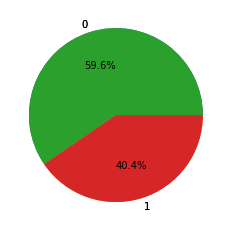

0    424
1    288
Name: Survived, dtype: int64

In [ ]:
values_drop = df_drop['Survived'].value_counts()
labels = df_drop['Survived'].unique()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(values_drop, labels=labels, autopct='%1.1f%%')
ax.pie(values_drop, labels=labels)
plt.show()
values_drop

In [ ]:
X_drop = pd.get_dummies(df_drop.drop('Survived', axis = 1))
y_drop = df_drop['Survived']
df_drop.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.356462,0.536762,-0.082446,-0.015523,0.095265,0.266100
Pclass,-0.356462,1.000000,-0.150826,-0.365902,0.065187,0.023666,-0.552893
Sex,0.536762,-0.150826,1.000000,-0.099037,0.106296,0.249543,0.182457
Age,-0.082446,-0.365902,-0.099037,1.000000,-0.307351,-0.187896,0.093143
SibSp,-0.015523,0.065187,0.106296,-0.307351,1.000000,0.383338,0.139860
Parch,0.095265,0.023666,0.249543,-0.187896,0.383338,1.000000,0.206624
Fare,0.266100,-0.552893,0.182457,0.093143,0.139860,0.206624,1.000000


In [ ]:
df_drop_lr = df_drop.copy()
df_drop_lr['p1'] = np.where(df_drop_lr['Pclass'] == 1, 1, 0)
df_drop_lr['p2'] = np.where(df_drop_lr['Pclass'] == 2, 1, 0)
df_drop_lr['p3'] = np.where(df_drop_lr['Pclass'] == 3, 1, 0)
df_drop_lr = df_drop_lr.drop('Pclass', axis = 1)
df_drop_lr = pd.get_dummies(df_drop_lr)
df_drop_lr.drop('SibSp', axis = 1).corr()
X_drop_lr = df_drop_lr.drop('Survived', axis = 1)
y_drop_lr = df_drop_lr['Survived']

In [ ]:
sc = StandardScaler()
features= X_drop_lr.columns
X_drop_lr[features] = sc.fit_transform(X_drop_lr[features])

In [ ]:
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size = 0.1, random_state = 42)
X_drop_train_lr, X_drop_test_lr, y_drop_train_lr, y_drop_test_lr = train_test_split(X_drop_lr, y_drop_lr, test_size = 0.1, random_state = 42)

In [ ]:
lr_drop = LogisticRegression(solver='lbfgs', random_state = 42)
cb_drop = CatBoostClassifier()
rf_drop = RandomForestClassifier()
xgb_drop = XGBClassifier(random_state = 42)
xgbrf_drop = XGBRFClassifier()


In [ ]:
parametrs_lr = {'penalty': ['l2'],
                'C' : np.logspace(-3, 3, 50),
                }

parametrs_rf = {'n_estimators':[100, 200, 300, 350, 400,  500],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split' : [2, 5, 10, 20],
                'min_samples_leaf':[2, 10, 30, 40],
                'max_depth' : [3, 5, 10, 20]
                  }

parametrs_cb = {'n_estimators': [50,100,250,400,600],
             'learning_rate': [0.2,0.5,0.8,1],
             'l2_leaf_reg': [1, 3, 5, 7, 9]
             }


parametrs_xgb = {'n_estimators': [50,100,250,400,600,800,1000],
              'learning_rate': [0.2,0.5,0.8,1]
              }

parametrs_xgbrf = {'n_estimators': [50,100,250,400,600,800,1000],
                'max_depth' : [3, 5, 10, 20],
                'learning_rate': [0.2,0.5,0.8,1]
                }



In [ ]:
lr_1 = GridSearchCV(lr_drop, parametrs_lr, cv =5)
rf_1 = RandomizedSearchCV(rf_drop, parametrs_rf, cv=5)
cb_1 = GridSearchCV(cb_drop, parametrs_cb, cv=5)
xgb_1 = GridSearchCV(xgb_drop, parametrs_xgb, cv=5)
xgbrf_1 = GridSearchCV(xgbrf_drop, parametrs_xgbrf, cv=5)

In [ ]:
lr_1.fit(X_drop_train_lr, y_drop_train_lr)
rf_1.fit(X_drop_train, y_drop_train)
cb_1.fit(X_drop_train, y_drop_train)
xgb_1.fit(X_drop_train, y_drop_train)
xgbrf_1.fit(X_drop_train, y_drop_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

Streaming output truncated to the last 5000 lines.
100:	learn: 0.0513882	total: 104ms	remaining: 307ms
101:	learn: 0.0512996	total: 105ms	remaining: 306ms
102:	learn: 0.0512977	total: 106ms	remaining: 305ms
103:	learn: 0.0512705	total: 107ms	remaining: 304ms
104:	learn: 0.0512701	total: 108ms	remaining: 303ms
105:	learn: 0.0512615	total: 109ms	remaining: 302ms
106:	learn: 0.0511547	total: 110ms	remaining: 301ms
107:	learn: 0.0511126	total: 111ms	remaining: 300ms
108:	learn: 0.0504692	total: 112ms	remaining: 298ms
109:	learn: 0.0493676	total: 113ms	remaining: 297ms
110:	learn: 0.0483947	total: 114ms	remaining: 296ms
111:	learn: 0.0483101	total: 115ms	remaining: 295ms
112:	learn: 0.0481456	total: 117ms	remaining: 297ms
113:	learn: 0.0480711	total: 118ms	remaining: 296ms
114:	learn: 0.0477798	total: 120ms	remaining: 297ms
115:	learn: 0.0471913	total: 122ms	remaining: 298ms
116:	learn: 0.0466628	total: 128ms	remaining: 309ms
117:	learn: 0.0459397	total: 129ms	remaining: 308ms
118:	learn: 0

GridSearchCV(cv=5, estimator=XGBRFClassifier(),
             param_grid={'learning_rate': [0.2, 0.5, 0.8, 1],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [50, 100, 250, 400, 600, 800, 1000]})

In [ ]:
models = [('Random Forest', rf_1.best_estimator_),
          ('Cat Boost', cb_1.best_estimator_),
          ('XGB', xgb_1.best_estimator_),
          ('XGBRF', xgbrf_1.best_estimator_)]


In [ ]:
y_pred = lr_1.best_estimator_.predict(X_drop_test_lr)
accuracy = accuracy_score(y_drop_test_lr,y_pred)
print('{:s} : {:.3f}'.format('Logistic Regression', accuracy))

for model_name, model in models:

    # Predict y_pred
    y_pred = model.predict(X_drop_test)
    accuracy = accuracy_score(y_drop_test, y_pred)



    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(model_name, accuracy))

Logistic Regression : 0.819
Random Forest : 0.819
Cat Boost : 0.806
XGB : 0.778
XGBRF : 0.792


In [ ]:
best_estimator = rf_1.best_estimator_

In [ ]:
test = pd.read_csv('./test.csv')
passengers = test['PassengerId']
test.Sex = np.where(test.Sex == 'female', 1, 0)
test.Age = test.Age.fillna(test.Age.median())
test.Fare = test.Fare.fillna(test.Fare.median())
test = pd.get_dummies(test.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1))
test.isna().sum()


Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [ ]:
y_test = best_estimator.predict(test)
y_test = pd.Series(y_test, name ='Survived')
answer1 = pd.concat([passengers, y_test], axis = 1)
answer1.to_csv('answer_rf.csv', index=False)


In [ ]:
best_estimator

RandomForestClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=300)